# (Kaggle PetFinder) Model Baseline 

## Imports

In [4]:
!pip install --upgrade pip -q
!pip install s3fs -q
!pip install -U spacy -q
!python -m spacy download en_core_web_sm -q
!python -m spacy download en -q
!pip install catboost -q
!pip install opencv-python -q

[+] Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [5]:
from mxnet_utils import *
%matplotlib inline

## Loading data from S3

In [4]:
breeds = pd.read_csv('s3://petfinder-fra/breed_labels.csv')
colors = pd.read_csv('s3://petfinder-fra/color_labels.csv')
states = pd.read_csv('s3://petfinder-fra/state_labels.csv')
train = pd.read_csv('s3://petfinder-fra/train.csv')
train.columns = [c.lower() for c in train.columns]
train.set_index('petid', inplace=True)

In [5]:
train.head().T

petid,86e1089a3,6296e909a,3422e4906,5842f1ff5,850a43f90
type,2,2,1,1,1
name,Nibble,No Name Yet,Brisco,Miko,Hunter
age,3,1,1,4,1
breed1,299,265,307,307,307
breed2,0,0,0,0,0
gender,1,1,1,2,1
color1,1,1,2,1,1
color2,7,2,7,2,0
color3,0,0,0,0,0
maturitysize,1,2,2,2,2


## Adding sentiment of pets' description to main dataset

In [8]:
def read_sentiment(obj):
    data = json.load(obj.get()['Body'])
    return {'petid': obj.key.split("/")[1][:-5], 'score': data['documentSentiment']['score'], 'magnitude': data['documentSentiment']['magnitude'], 'lang': data['language']}

def get_sentiments():
    s3 = boto3.resource('s3')
    return pd.DataFrame([read_sentiment(i) for i in s3.Bucket("petfinder-fra").objects.filter(Prefix='train_sentiment')])

In [6]:
sents = get_sentiments()
sents.set_index('petid', inplace=True)
sents.head()

,score,magnitude,lang
petid,,,
0008c5398,0.7,2.8,en
000a290e4,0.3,0.6,en
000fb9572,0.3,0.8,en
0011d7c25,0.8,0.8,en
00156db4a,0.0,1.8,en


In [7]:
data = train.join(sents)
data.description.fillna("missing", inplace=True)
assert (len(train)-len(sents)) == len(data.loc[pd.isnull(data.score)])

In [9]:
data.shape

(14993, 26)

In [11]:
data.loc[:,['score', 'magnitude']] = data.loc[:,['score', 'magnitude']].fillna(0.0)

In [13]:
data.to_csv('data.csv')

## Tokenizing pets' description and encoding text with pre-trained word embeddings

In [3]:
data = pd.read_csv('data.csv')

In [4]:
data.lang.value_counts(dropna=False, normalize=True)*100

en         95.437871
NaN         3.675048
zh          0.633629
zh-Hant     0.240112
de          0.013340
Name: lang, dtype: float64

In [5]:
tokenizer = nlp.data.SpacyTokenizer()

In [6]:
text = data.loc[~pd.isnull(data.lang)].description.sample().values[0]
print(f"ORIGINAL TEXT: {text}\n")
print(f"TOKENIZED TEXT: {tokenizer(text)}")

ORIGINAL TEXT: 2 years old mixed terrier welsh corgi waiting to rehome,owner not free time to take care,and very good temperament and friendly.if any pets lover interesting to adopt owner will free for rehome.pls cal mdm may

TOKENIZED TEXT: ['2', 'years', 'old', 'mixed', 'terrier', 'welsh', 'corgi', 'waiting', 'to', 'rehome', ',', 'owner', 'not', 'free', 'time', 'to', 'take', 'care', ',', 'and', 'very', 'good', 'temperament', 'and', 'friendly.if', 'any', 'pets', 'lover', 'interesting', 'to', 'adopt', 'owner', 'will', 'free', 'for', 'rehome.pls', 'cal', 'mdm', 'may']


In [7]:
w2v = nlp.embedding.create(embedding_name='fasttext', source='wiki.simple')

In [11]:
w2v['kitten'][:20]


[ 0.46491  -0.054671 -0.15154  -0.043841  0.066584  0.28697  -0.039378
 -0.11509   0.35755   0.31213   0.02738   0.098974 -0.12107   0.53368
  0.19042  -0.32068  -0.1207   -0.18608  -0.016929 -0.094216]
<NDArray 20 @cpu(0)>

In [12]:
def embed_desc(desc):
    toks = tokenizer(desc)
    e = [w2v[w].asnumpy() for w in toks]
    return np.stack(e).mean(axis=0).tolist()+[len(toks)]

In [13]:
embed_desc(text)[-5:]

[-0.1949036568403244,
 -0.0573563314974308,
 -0.09666246920824051,
 -0.16454443335533142,
 39]

In [14]:
data[[f"vec_{i}" for i in range(300)]+["len_desc"]] = data.apply(lambda row: embed_desc(row.description), axis='columns', result_type='expand')

In [15]:
data.shape

(14993, 328)

In [16]:
data.head()

,petid,type,name,age,breed1,breed2,gender,color1,color2,color3,...,vec_291,vec_292,vec_293,vec_294,vec_295,vec_296,vec_297,vec_298,vec_299,len_desc
0,86e1089a3,2,Nibble,3,299,0,1,1,7,0,...,-0.183482,-0.017556,0.063786,-0.062366,0.020300,-0.187230,-0.082071,-0.128731,-0.147769,77.0
1,6296e909a,2,No Name Yet,1,265,0,1,1,2,0,...,-0.236214,-0.033021,0.033291,-0.042864,0.035596,-0.118299,-0.114550,-0.097421,-0.147218,25.0
2,3422e4906,1,Brisco,1,307,0,1,2,7,0,...,-0.178662,0.001066,0.040389,-0.024360,0.035955,-0.135899,-0.075400,-0.098855,-0.154870,78.0
3,5842f1ff5,1,Miko,4,307,0,2,1,2,0,...,-0.174424,-0.077134,0.053265,-0.013152,0.003189,-0.174559,-0.101790,-0.103146,-0.167394,32.0
4,850a43f90,1,Hunter,1,307,0,1,1,0,0,...,-0.165067,-0.009924,0.038587,-0.010370,0.037135,-0.194724,-0.072124,-0.120098,-0.162652,88.0


In [17]:
data.to_csv('data.csv')

## Enriching dataset with convolutional features from pets' pictures

In [3]:
data = pd.read_csv('data.csv')
data.set_index('petid', inplace=True)

In [4]:
model_name = 'ResNet18_v1'
net = cv.model_zoo.get_model(model_name, pretrained=True)
img = mx.image.imread('./train_images/0008c5398-1.jpg')
transformed_img = cv.data.transforms.presets.imagenet.transform_eval(img)
cv_feats = net.features(transformed_img)

In [5]:
cv_feats.squeeze().shape

(512,)

In [6]:
len(data.loc[data.photoamt>0])/len(data)

0.9772560528246516

In [7]:
def get_image_names(row):
    if int(row.photoamt)==0: return []
    return [f"./train_images/{row.name}-{i}.jpg" for i in range(1, int(row.photoamt)+1)]

def extract_image_feats(fn):
    img = mx.image.imread(fn)
    transformed_img = cv.data.transforms.presets.imagenet.transform_eval(img)
    return net.features(transformed_img).squeeze()

def images_features(row):
    fnames = get_image_names(row)
    if len(fnames)==0: return np.zeros(512).tolist()
    feats = [extract_image_feats(fn).asnumpy() for fn in fnames]
    return np.stack(feats).mean(axis=0).tolist()

In [9]:
len(extract_image_feats('./train_images/bf6ef8c07-1.jpg'))

512

In [10]:
len(images_features(data.loc['bf6ef8c07']))

512

In [11]:
data[[f"cv_{i}" for i in range(512)]] = data.apply(lambda row: images_features(row), axis='columns', result_type='expand')

In [12]:
data.shape

(14993, 840)

In [14]:
data.head()

,Unnamed: 0,type,name,age,breed1,breed2,gender,color1,color2,color3,...,cv_502,cv_503,cv_504,cv_505,cv_506,cv_507,cv_508,cv_509,cv_510,cv_511
petid,,,,,,,,,,,,,,,,,,,,,
86e1089a3,0,2,Nibble,3,299,0,1,1,7,0,...,0.510474,0.876096,0.000000,0.780925,0.446994,0.896877,0.725181,0.703574,0.046233,1.920820
6296e909a,1,2,No Name Yet,1,265,0,1,1,2,0,...,0.032787,0.175013,0.603155,0.190126,0.918588,0.695201,0.725023,1.401867,0.686700,0.521794
3422e4906,2,1,Brisco,1,307,0,1,2,7,0,...,0.290392,0.274782,0.843916,0.736343,0.168040,2.268596,0.404377,0.367258,0.590765,0.826990
5842f1ff5,3,1,Miko,4,307,0,2,1,2,0,...,0.343140,0.429069,0.363940,0.803290,0.421142,1.704050,0.496805,1.062604,0.351337,0.725866
850a43f90,4,1,Hunter,1,307,0,1,1,0,0,...,0.662813,0.362385,0.131510,1.290741,0.768085,1.831410,0.278283,0.603773,0.399064,1.311060


In [13]:
data.to_csv('data.csv')

## Splitting data into training and validation

In [6]:
data = pd.read_csv('data.csv')
data[['name', 'lang']] = data[['name', 'lang']].fillna('missing')

In [12]:
X_train, X_valid, y_train, y_valid = split_data(data)
X_train.shape, X_valid.shape

((10870, 842), (4948, 842))

In [13]:
y_valid.value_counts()

4    1385
2    1332
3    1076
1    1020
0     135
Name: adoptionspeed, dtype: int64

In [14]:
y_train.value_counts()

4    2812
2    2705
3    2183
1    2070
0    1100
Name: adoptionspeed, dtype: int64

## Random Forest baseline

In [15]:
txt_feats = [c for c in data.columns if 'vec' in c]
cv_feats = [c for c in data.columns if 'cv' in c]
data_feats = ['type', 'age', 'breed1', 'breed2', 'gender', 'color1', 'color2', 'color3', 'maturitysize',
                 'furlength', 'vaccinated', 'dewormed', 'sterilized', 'health', 'quantity', 'fee', 'photoamt', 'score', 'magnitude', 'len_desc']

len(txt_feats), len(cv_feats), len(data_feats)

(300, 512, 20)

In [16]:
missing_values(X_train[txt_feats+cv_feats+data_feats])

,Total,Percent


In [17]:
rf = RandomForestClassifier(n_estimators=200, n_jobs=-1)
rf.fit(X_train[txt_feats+cv_feats+data_feats], y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Accuracy: 0.404
Cohen's Kappa: 0.33735
Kaggle winning Cohen's Kappa: 0.45338



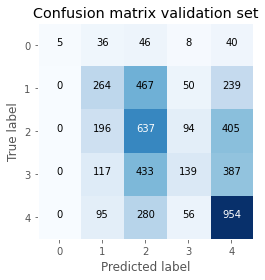

In [19]:
report(rf, X_valid[txt_feats+cv_feats+data_feats], y_valid)

## CatBoost

In [21]:
cats_feats = ['type', 'name', 'breed1', 'breed2', 'gender', 'color1', 'color2', 'color3', 'maturitysize', 'furlength',
             'vaccinated', 'dewormed', 'sterilized', 'health', 'lang', 'state']
num_feats = ['age', 'len_desc', 'quantity', 'fee', 'photoamt', 'score', 'magnitude']
txt_feats = [c for c in data.columns if 'vec' in c]
cv_feats = [c for c in data.columns if 'cv' in c]

In [22]:
missing_values(X_train[txt_feats+cv_feats+num_feats+cats_feats])

,Total,Percent


In [23]:
clf = CatBoostClassifier(iterations=2000,
                         learning_rate=0.01,
                         cat_features=cats_feats,
                         loss_function='MultiClass',
                         custom_metric='Accuracy')
                         
clf.fit(X_train[txt_feats+cv_feats+num_feats+cats_feats], y_train,
        eval_set=(X_valid[txt_feats+cv_feats+num_feats+cats_feats],y_valid),
        plot=False,
        use_best_model=True,
        verbose=False);

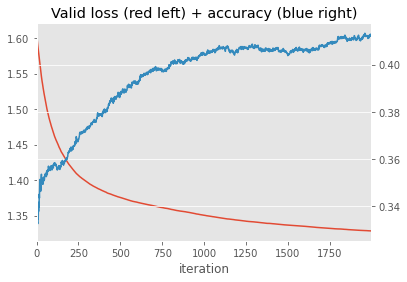

In [25]:
read_catboost().plot(x='iteration', y=['loss_valid', 'accuracy_valid'], secondary_y='accuracy_valid', legend=False, title="Valid loss (red left) + accuracy (blue right)");

Accuracy: 0.41249
Cohen's Kappa: 0.34955
Kaggle winning Cohen's Kappa: 0.45338



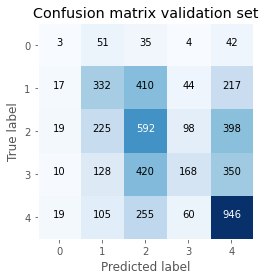

In [26]:
report(clf, X_valid[txt_feats+cv_feats+num_feats+cats_feats], y_valid)

### Remove unimportant variables and retrain

In [28]:
fi = get_feat_importance(clf, X_valid[txt_feats+cv_feats+num_feats+cats_feats], html=False)

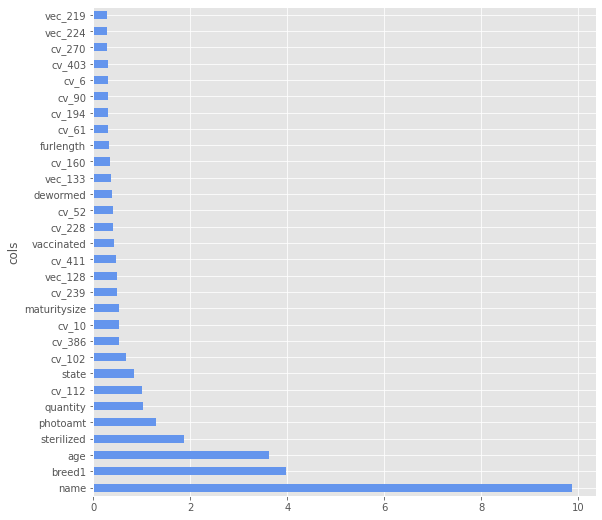

In [29]:
plot_fi(fi[:30]);

In [30]:
q = fi.imp.quantile(.33)
top = list(fi.loc[fi.imp > q].cols.values)
non_top = list(fi.loc[fi.imp <= q].cols.values)
q, len(top)

(0.05904183100186372, 559)

In [40]:
features = txt_feats+cv_feats+num_feats+cats_feats
features = [c for c in features if c in top]
cats_ = [c for c in cats_feats if c in top]
len(features), len(cats_)/len(cats_feats), len([c for c in cv_feats if c in top])/len(cv_feats), len([c for c in txt_feats if c in top])/len(txt_feats), len([c for c in num_feats if c in top])/len(num_feats) 

(559, 0.9375, 0.6328125, 0.7133333333333334, 0.8571428571428571)

In [34]:
len(txt_feats+cv_feats+num_feats+cats_feats), len(features)

(835, 559)

In [35]:
clf = CatBoostClassifier(iterations=2000,
                         learning_rate=0.01,
                         cat_features=cats_,
                         loss_function='MultiClass',
                         custom_metric='Accuracy')
                         
clf.fit(X_train[features], y_train,
        eval_set=(X_valid[features],y_valid),
        plot=False,
        use_best_model=True,
        verbose=False);

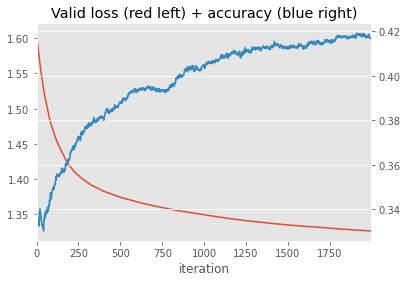

In [36]:
read_catboost().plot(x='iteration', y=['loss_valid', 'accuracy_valid'], secondary_y='accuracy_valid', legend=False, title="Valid loss (red left) + accuracy (blue right)");

Accuracy: 0.41673
Cohen's Kappa: 0.35644
Kaggle winning Cohen's Kappa: 0.45338



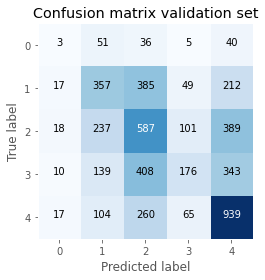

In [37]:
report(clf, X_valid[features], y_valid)

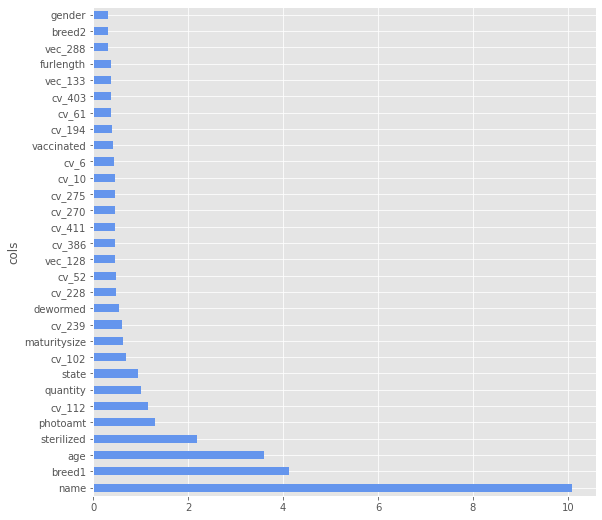

In [38]:
fi = get_feat_importance(clf, X_valid[features], html=False)
plot_fi(fi[:30]);

In [43]:
artifacts = {'catboost': clf, 'features': features, 'cat_feats': cats_, 'X_train': X_train, 'y_train': y_train, 'X_valid': X_valid, 'y_valid': y_valid}
save_artifact(artifacts, 'artifacts.pkl')

## CatBoost HPO

In [9]:
artifacts = load_artifact('artifacts.pkl')

In [10]:
features = artifacts['features']
X_train, y_train = artifacts['X_train'], artifacts['y_train']
X_valid, y_valid = artifacts['X_valid'], artifacts['y_valid']
cats_ = artifacts['cat_feats']

In [52]:
%%time
cat = CatBoostClassifier(task_type = "GPU",
                         cat_features=cats_,
                         loss_function='MultiClass')

grid = {'iterations': randint(1500, 2500),
        'depth': randint(4, 10),
        'learning_rate': 10**(np.random.uniform(1, 3, 10) * -1),
        'l2_leaf_reg': randint(2, 20)}

randomized_search_result = cat.randomized_search(grid, X=X_train[features], y=y_train)

bestTest = 1.216248289
bestIteration = 2416
0:	loss: 1.2162483	best: 1.2162483 (0)	total: 20.1s	remaining: 3m
bestTest = 1.216670537
bestIteration = 2071
1:	loss: 1.2166705	best: 1.2162483 (0)	total: 42.6s	remaining: 2m 50s
bestTest = 1.130761449
bestIteration = 1815
2:	loss: 1.1307614	best: 1.1307614 (2)	total: 3m 52s	remaining: 9m 1s
bestTest = 1.328097823
bestIteration = 2147
3:	loss: 1.3280978	best: 1.1307614 (2)	total: 4m 33s	remaining: 6m 49s
bestTest = 1.322226095
bestIteration = 2135
4:	loss: 1.3222261	best: 1.1307614 (2)	total: 8m 13s	remaining: 8m 13s
bestTest = 1.113805917
bestIteration = 1682
5:	loss: 1.1138059	best: 1.1138059 (5)	total: 9m 6s	remaining: 6m 4s
bestTest = 1.30942129
bestIteration = 1905
6:	loss: 1.3094213	best: 1.1138059 (5)	total: 9m 20s	remaining: 4m
bestTest = 1.281281444
bestIteration = 1615
7:	loss: 1.2812814	best: 1.1138059 (5)	total: 9m 38s	remaining: 2m 24s
bestTest = 1.257052003
bestIteration = 1906
8:	loss: 1.2570520	best: 1.1138059 (5)	total: 12m 

In [58]:
randomized_search_result['params']

{'depth': 7.0,
 'learning_rate': 0.024983605347286955,
 'l2_leaf_reg': 2.0,
 'iterations': 1683.0}

In [67]:
report(cat, X_valid[features], y_valid, conf=False)

Accuracy: 0.42138
Cohen's Kappa: 0.36992
Kaggle winning Cohen's Kappa: 0.45338



In [65]:
artifacts = {'catboost': cat, 'features': features, 'cat_feats': cats_, 'X_train': X_train, 'y_train': y_train, 'X_valid': X_valid, 'y_valid': y_valid}
save_artifact(artifacts, 'artifacts.pkl')